# Import libraries and set directories/filepaths

In [31]:
COLLAB = False

In [32]:
if COLLAB:
    from google.colab import drive
    drive.mount('/content/drive')

In [33]:
!pip install monai
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.nn as nn
import numpy as np
import glob
import os
import sys
import gc
import matplotlib.pyplot as plt
from torchvision.transforms import v2
import seaborn as sns
import monai

# Include src directory in path to import custom modules
if os.path.join("..", "src") not in sys.path:
    sys.path.append(os.path.join("..", "src"))

In [34]:
os.getcwd()

'C:\\Users\\james\\Documents\\projects\\pred-knee-replacement-oai\\src'

In [35]:
if COLLAB:
    os.chdir("/content/drive/MyDrive/Projects/PhD/pred-knee-replacement-oai/src/")
else:
    os.chdir("C:/Users/james/Documents/projects/pred-knee-replacement-oai/src")



In [39]:
cur_dir = os.getcwd()

print(f"The current working directory is: {cur_dir}")

print(f"The contents of this directory: {os.listdir()}")


The current working directory is: C:\Users\james\Documents\projects\pred-knee-replacement-oai\src
The contents of this directory: ['config', 'data', 'features', 'metrics', 'models', 'scripts', 'test.py', 'train.py', 'trainer', 'utils', 'visualization', 'wandb', '__init__.py', '__pycache__']


In [40]:
# Track reloads of custom modules - https://stackoverflow.com/questions/64158622/jupyter-does-not-see-changes-in-the-imported-module
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
import importlib

from models.model_unet import UNet3D, UNet3DMulticlass
import metrics.loss
importlib.reload(metrics.loss) # reload step 1
from metrics.loss import dice_coefficient_multi_batch, dice_coefficient_multi_batch_all

import data.datasets
importlib.reload(data.datasets)
from data.datasets import KneeSegDataset3DMulticlass

import utils.utils
importlib.reload(utils.utils)
from utils.utils import crop_im, crop_mask


In [23]:
# Set Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Current device: {device}")

Current device: cpu


In [50]:
# Define data directories

if COLLAB:
    DATA_DIRECTORY = "/content/drive/MyDrive/Career/PhD/Project/Data"
    DATA_TEST_DIRECTORY = "/content/drive/MyDrive/Career/PhD/Project/Data/test"
    DATA_PROCESSED_DIRECTORY = "/content/drive/MyDrive/Projects/PhD/pred-knee-replacement-oai/data/processed"
    RESULTS_PATH = os.path.join('..', 'results')
    RESULTS_FIGURES_PATH = os.path.join('..', 'results', 'figures')
else:
    DATA_DIRECTORY = "C:/Users/james/OneDrive - University of Leeds/1. Projects/1.1 PhD/1.1.1 Project/Data/OAI Subset"
    DATA_TEST_DIRECTORY = "C:/Users/james/OneDrive - University of Leeds/1. Projects/1.1 PhD/1.1.1 Project/Data/OAI Subset/test"
    DATA_PROCESSED_DIRECTORY = os.path.join('..', 'data', 'processed')
    RESULTS_PATH = os.path.join('..', 'results')
    RESULTS_FIGURES_PATH = os.path.join('..', 'results', 'figures')




# Define test file paths
test_gt_mask_paths = [os.path.basename(x).split(".")[0] for x in glob.glob(os.path.join(DATA_TEST_DIRECTORY, "*"))]
print(f"Number of test images: {len(test_gt_mask_paths)}")
print(f"Test paths first example: {test_gt_mask_paths[0:3]}")


Number of test images: 28
Test paths first example: ['test_001_V00', 'test_001_V01', 'test_002_V00']


# Calculate evaluation metrics

In [51]:
# Define Dice Coefficient for two masks
def dice_coefficient(mask1, mask2):
    intersection = torch.sum(mask1 * mask2)
    sum = mask1.sum().item() + mask2.sum().item()
    dice = (2.0 * intersection) / sum
    return dice.item()

In [52]:
def calculate_eval_metrics(data_dir, data_processed_dir, test_paths, filename_prefix):

  tissue_labels = ["Femoral cart.", "Tibial cart.", "Patellar cart.", "Meniscus"]
  num_classes = len(tissue_labels)


  all_dice_scores = []
  all_dice_scores_all_classes = []
  all_assd_all_classes = []
  all_voe_all_classes = []

  for filename in test_paths:
    print(f"\n{filename}")

    # Load ground truth mask
    print(f"\n Ground truth file: {filename}.npy")
    gt_mask = np.load(os.path.join(data_dir, "test_gt", filename + ".npy"))
    # Move classes dimension to be firt dimension
    gt_mask = np.transpose(gt_mask, (3,0,1,2))
    # Crop ground truth to match predicted
    gt_mask = crop_mask(gt_mask, dim1_lower=56, dim1_upper=312, dim2_lower=58, dim2_upper=314)

    # Load predicted binary mask
    print(f"\n Predicted mask file: {filename_prefix}_{filename}.npy")
    pred_mask = np.load(os.path.join(data_processed_dir, filename_prefix + "_" + filename + ".npy"))
    # Remove first dim of 1 (batch)
    pred_mask = pred_mask.squeeze(axis=0)
    # Remove background
    pred_mask = pred_mask[1:,:,:,:]

    im_dice_scores = []


    #########################################################################
    # DICE SCORES
    #########################################################################
    # Dice dice for all classes together
    dice_score_all_classes = dice_coefficient(torch.tensor(gt_mask), torch.tensor(pred_mask))
    print(f"Dice score for all classes together: {dice_score_all_classes}")
    all_dice_scores_all_classes.append(dice_score_all_classes)

    for class_idx in range(num_classes):
      dice_score = dice_coefficient(torch.tensor(gt_mask[class_idx,...]), torch.tensor(pred_mask[class_idx,...]))
      print(f"Dice score for class {tissue_labels[class_idx]}: {dice_score}")
      im_dice_scores.append(dice_score)

    print(f"{filename} Average Dice score (class average): {np.mean(im_dice_scores)}")

    all_dice_scores.append(im_dice_scores)

    #########################################################################
    # ASSD
    #########################################################################

    # ASSD function expects batch dimension so add dim back
    pred_mask = np.expand_dims(pred_mask, axis=0)
    gt_mask = np.expand_dims(gt_mask, axis=0)

    # Compute ASSD - [0.36,0.36,0.7] is voxel resolution
    assd = monai.metrics.compute_average_surface_distance(pred_mask, gt_mask, symmetric=True, include_background=True, spacing=[0.36,0.36,0.7])
    print(f"ASSD score: {assd}")

    all_assd_all_classes.append(assd.tolist())

    #########################################################################
    # VOE
    #########################################################################
    # Compute VOE as (1 - IOU)
    IOU = monai.metrics.compute_iou(torch.tensor(pred_mask), torch.tensor(gt_mask), include_background=True)
    VOE = 1 - IOU
    print(f"VOE score: {VOE}")

    all_voe_all_classes.append(VOE.tolist())

  #############################################
  # REPORT RESULTS
  #############################################
  all_dice_scores = np.array(all_dice_scores)
  print(all_dice_scores.shape)
  print(f"Average Dice score (): {np.mean(all_dice_scores, axis=0)}")

  all_assd_all_classes = np.array(all_assd_all_classes)
  print(all_assd_all_classes.shape)
  print(f"Average ASSD score (): {np.mean(all_assd_all_classes, axis=0)}")

  all_voe_all_classes = np.array(all_voe_all_classes)
  print(all_voe_all_classes.shape)
  print(f"Average VOE score (): {np.mean(all_voe_all_classes, axis=0)}")


  #############################################
  # SAVE RESULTS
  #############################################
  # Save results to file
  np.save(os.path.join(RESULTS_PATH, filename_prefix + "_" + "dice_scores_by_image_tissue.npy"), all_dice_scores)
  np.save(os.path.join(RESULTS_PATH, filename_prefix + "_" + "assd_by_image_tissue.npy"), all_assd_all_classes.squeeze(axis=1))
  np.save(os.path.join(RESULTS_PATH, filename_prefix + "_" + "voe_by_image_tissue.npy"), all_voe_all_classes.squeeze(axis=1))


In [53]:
# Calculate eval metrics for MANet
calculate_eval_metrics(data_dir=DATA_DIRECTORY, data_processed_dir=DATA_PROCESSED_DIRECTORY, test_paths=test_gt_mask_paths, filename_prefix="manet")


test_001_V00

 Ground truth file: test_001_V00.npy

 Predicted mask file: manet_test_001_V00.npy


FileNotFoundError: [Errno 2] No such file or directory: '..\\data\\processed\\manet_test_001_V00.npy'

In [ ]:
# Calculate eval metrics for U-Net
calculate_eval_metrics(data_dir=DATA_DIRECTORY, data_processed_dir=DATA_PROCESSED_DIRECTORY, test_paths=test_gt_mask_paths, filename_prefix="")

## Visualise U-Net Results

In [ ]:
# Load U-Net results
all_dice_scores = np.load(os.path.join(RESULTS_PATH, "dice_scores_by_image_tissue.npy"))
all_assd_all_classes = np.load(os.path.join(RESULTS_PATH, "assd_by_image_tissue.npy"))
all_voe_all_classes = np.load(os.path.join(RESULTS_PATH, "voe_by_image_tissue.npy"))

In [ ]:
# Print results summary
print(f"Average Dice scores by class: {np.mean(all_dice_scores, axis=0)}")
print(f"Dice Standard deviation by class: {np.std(all_dice_scores, axis=0)}\n")

print(f"Average ASSD by class: {np.mean(all_assd_all_classes, axis=0)}")
print(f"ASSD Standard deviation by class: {np.std(all_assd_all_classes, axis=0)}\n")

print(f"Average VOE by class: {np.mean(all_voe_all_classes, axis=0)}")
print(f"VOE Standard deviation by class: {np.std(all_voe_all_classes, axis=0)}")

Average Dice scores by class: [0.89038798 0.87044328 0.83737271 0.86775852]
Dice Standard deviation by class: [0.0196461  0.036194   0.08049821 0.02771924]

Average ASSD by class: [0.23659025 0.31035149 0.42748232 0.36537617]
ASSD Standard deviation by class: [0.02954349 0.18552363 0.60053689 0.08615763]

Average VOE by class: [0.19700768 0.22762739 0.27236088 0.23253895]
VOE Standard deviation by class: [0.03166155 0.0551583  0.10732154 0.04304123]


# Visualise evaluation metrics

In [ ]:
all_dice_scores.shape

(28, 4)

In [ ]:
def violin_plot(data, ylabel, title, filename, ref_high, ref_low, remove_patellar=False):
  tissue_labels = ["Femoral cart.", "Tibial cart.", "Patellar cart.", "Meniscus"]
  rc1 = {'font.family' : 'DeJavu Serif', 'font.serif': 'Computer Modern'}
  with plt.rc_context(rc1):

    # creating a dictionary with one specific color per group:
    my_pal = {
        0: "g",
        1: "y",
        2: "b",
        3: "r",
    }

    xticks = [0,1,2,3]

    if remove_patellar:
      data = np.delete(data, 2, axis=1)
      tissue_labels = ["Femoral cart.", "Tibial cart.", "Meniscus"]
      xticks = [0,1,2]

      # creating a dictionary with one specific color per group:
      my_pal = {
          0: "g",
          1: "y",
          2: "r",
      }

    fig, ax = plt.subplots(1, figsize=(8, 8))
    ax.grid(True, axis='y', color="0.7")
    ax.set_axisbelow(True)

    plt.ylabel(ylabel, fontsize=22)
    plt.xticks(xticks, tissue_labels, fontsize=22, rotation=25)
    plt.yticks(fontsize=22)
    plt.title(title, fontsize=24)

    ax = sns.violinplot(data=data, alpha=0.85, palette=my_pal)


    # set the position of the thresholds for each category

    # get the y-positions of the tick label for each category
    xpos = {c.get_text(): x for c, x in zip(ax.get_xticklabels(), ax.get_xticks())}

    # plot the threshold lines
    for tis in tissue_labels:
        ax.plot(
            [xpos[tis] - 0.2, xpos[tis] + 0.2],
            [ref_high[tis], ref_high[tis]],
            color="k",
            linestyle='dotted',
            lw=2,
        )

    # plot the threshold lines
    for tis in tissue_labels:
        ax.plot(
            [xpos[tis] - 0.2, xpos[tis] + 0.2],
            [ref_low[tis], ref_low[tis]],
            color="k",
            linestyle='dotted',
            lw=2,
        )

    plt.savefig(os.path.join(RESULTS_FIGURES_PATH, filename), bbox_inches="tight", dpi=500)
    plt.show()

In [ ]:
# Set high and low references from IWOAI
iwoai_dice_high = {
        "Femoral cart.": 0.90,
        "Tibial cart.": 0.89,
        "Patellar cart.": 0.86,
        "Meniscus": 0.88
      }

iwoai_dice_low = {
        "Femoral cart.": 0.87,
        "Tibial cart.": 0.85,
        "Patellar cart.": 0.83,
        "Meniscus": 0.83
      }



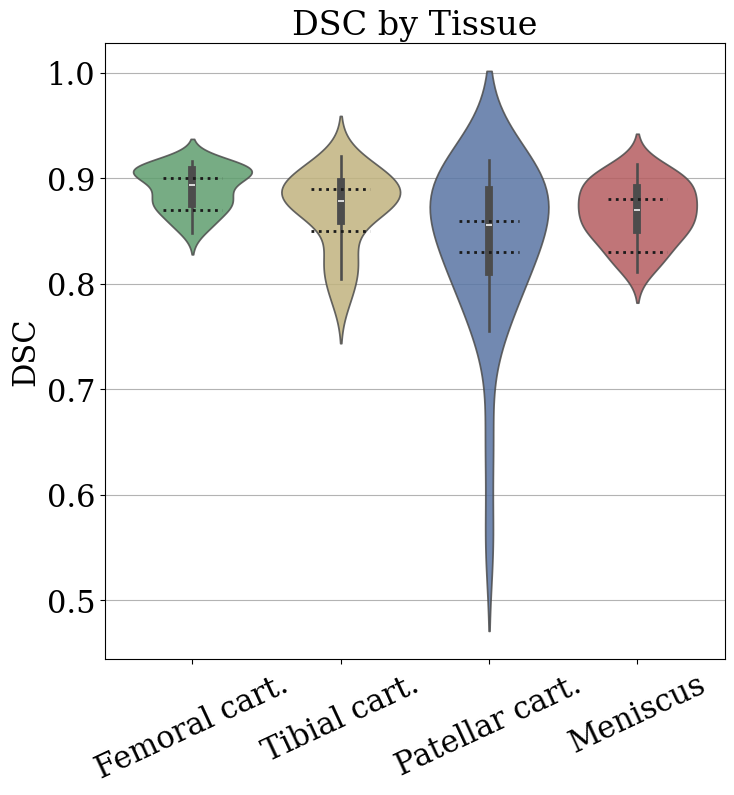

In [ ]:
violin_plot(
    data=all_dice_scores,
    ylabel="DSC",
    title="DSC by Tissue",
    filename="dice_by_tissue_violin",
    ref_high=iwoai_dice_high,
    ref_low=iwoai_dice_low,
  )

In [ ]:
iwoai_assd_high = {
        "Femoral cart.": 0.28,
        "Tibial cart.": 0.33,
        "Patellar cart.": 0.44,
        "Meniscus": 0.44
      }
iwoai_assd_low = {
        "Femoral cart.": 0.20,
        "Tibial cart.": 0.26,
        "Patellar cart.": 0.26,
        "Meniscus": 0.33
      }


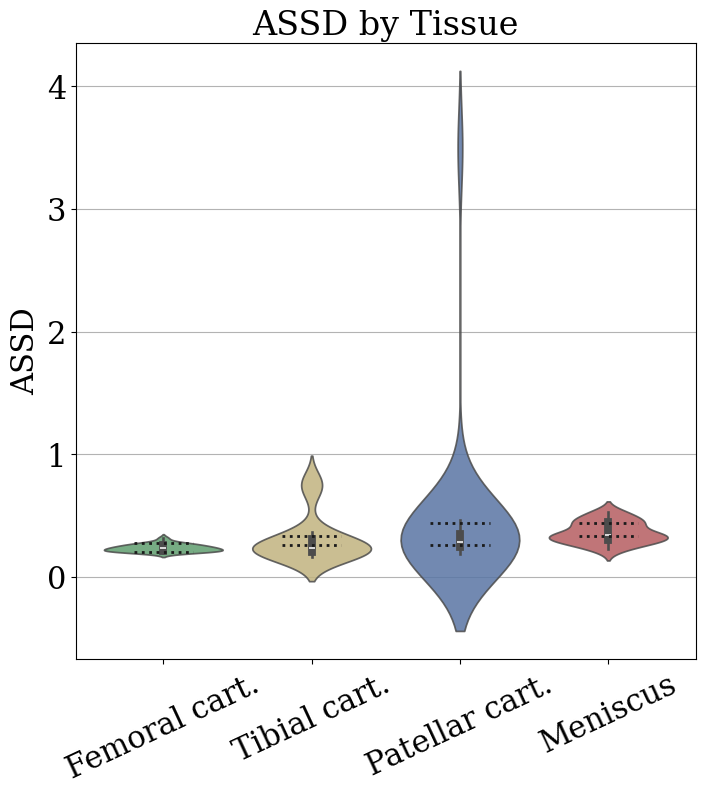

In [ ]:
violin_plot(
    data=all_assd_all_classes,
    ylabel="ASSD",
    title="ASSD by Tissue",
    filename="assd_by_tissue_violin",
    ref_high=iwoai_assd_high,
    ref_low = iwoai_assd_low
  )

In [ ]:
iwoai_voe_high = {
        "Femoral cart.": 0.22,
        "Tibial cart.": 0.26,
        "Patellar cart.": 0.29,
        "Meniscus": 0.28
      }
iwoai_voe_low = {
        "Femoral cart.": 0.17,
        "Tibial cart.": 0.20,
        "Patellar cart.": 0.24,
        "Meniscus": 0.22
      }

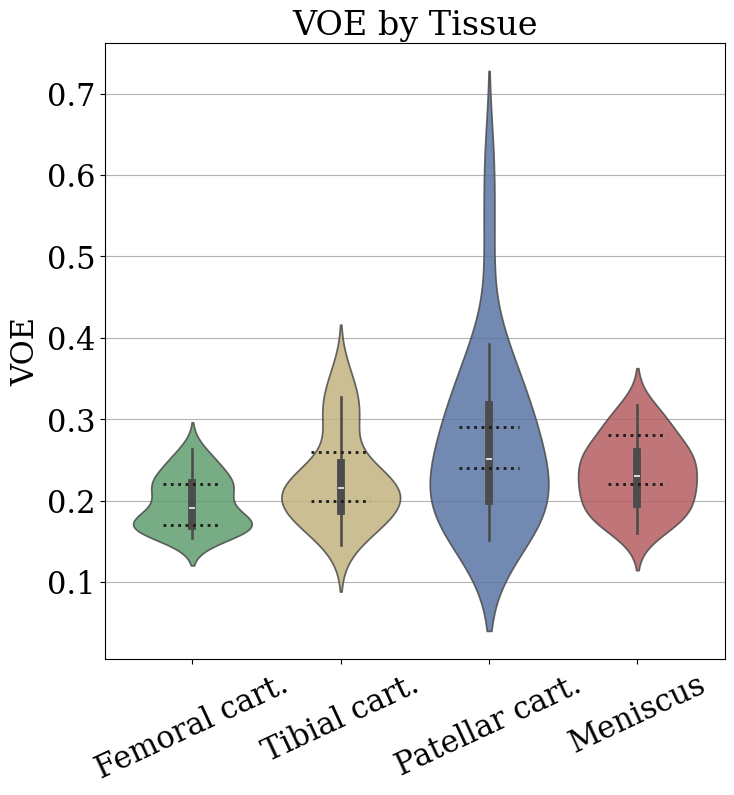

In [ ]:
violin_plot(
    data=all_voe_all_classes,
    ylabel="VOE",
    title="VOE by Tissue",
    filename="voe_by_tissue_violin",
    ref_high=iwoai_voe_high,
    ref_low=iwoai_voe_low
)

## Visualise MANet Results

In [ ]:
# Load U-Net results
manet_all_dice_scores = np.load(os.path.join(RESULTS_PATH, "manet_dice_scores_by_image_tissue.npy"))
manet_all_assd_all_classes = np.load(os.path.join(RESULTS_PATH, "manet_assd_by_image_tissue.npy"))
manet_all_voe_all_classes = np.load(os.path.join(RESULTS_PATH, "manet_voe_by_image_tissue.npy"))

In [ ]:
# Print results summary
print(f"Average Dice scores by class: {np.mean(manet_all_dice_scores, axis=0)}")
print(f"Dice Standard deviation by class: {np.std(manet_all_dice_scores, axis=0)}\n")

print(f"Average ASSD by class: {np.mean(manet_all_assd_all_classes, axis=0)}")
print(f"ASSD Standard deviation by class: {np.std(manet_all_assd_all_classes, axis=0)}\n")

print(f"Average VOE by class: {np.mean(manet_all_voe_all_classes, axis=0)}")
print(f"VOE Standard deviation by class: {np.std(manet_all_voe_all_classes, axis=0)}")

Average Dice scores by class: [0.87635585 0.73003403 0.         0.85625163]
Dice Standard deviation by class: [0.03845411 0.07528288 0.         0.02163576]

Average ASSD by class: [ 0.2794111   0.66760981 48.62165124  0.41128339]
ASSD Standard deviation by class: [0.13904482 0.31626337 4.45311673 0.0741098 ]

Average VOE by class: [0.21814239 0.41943175 1.         0.25073181]
VOE Standard deviation by class: [0.05664486 0.0968626  0.         0.03340438]


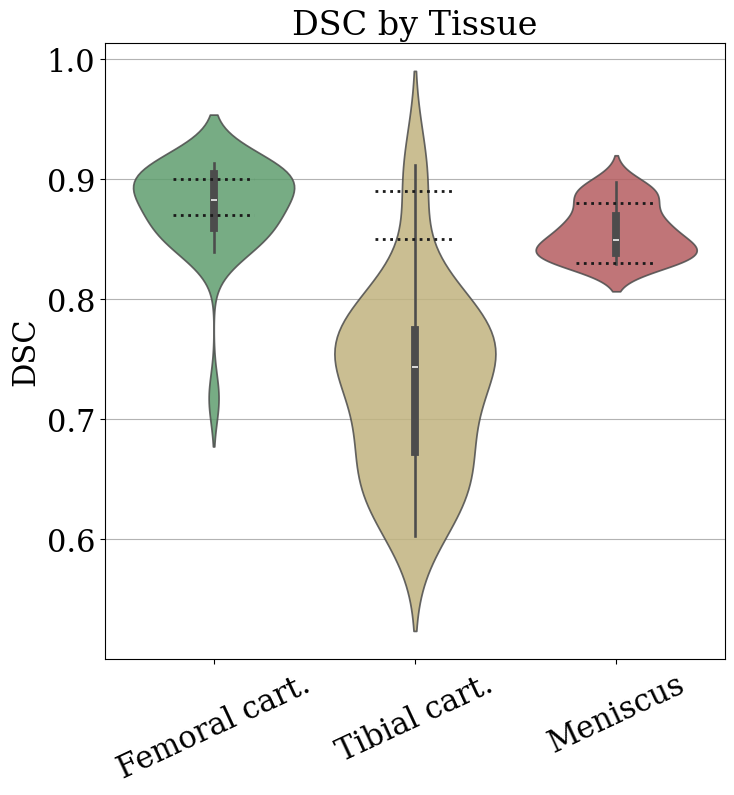

In [ ]:
violin_plot(
    data=manet_all_dice_scores,
    ylabel="DSC",
    title="DSC by Tissue",
    filename="manet_dice_by_tissue_violin",
    ref_high=iwoai_dice_high,
    ref_low=iwoai_dice_low,
    remove_patellar=True
  )

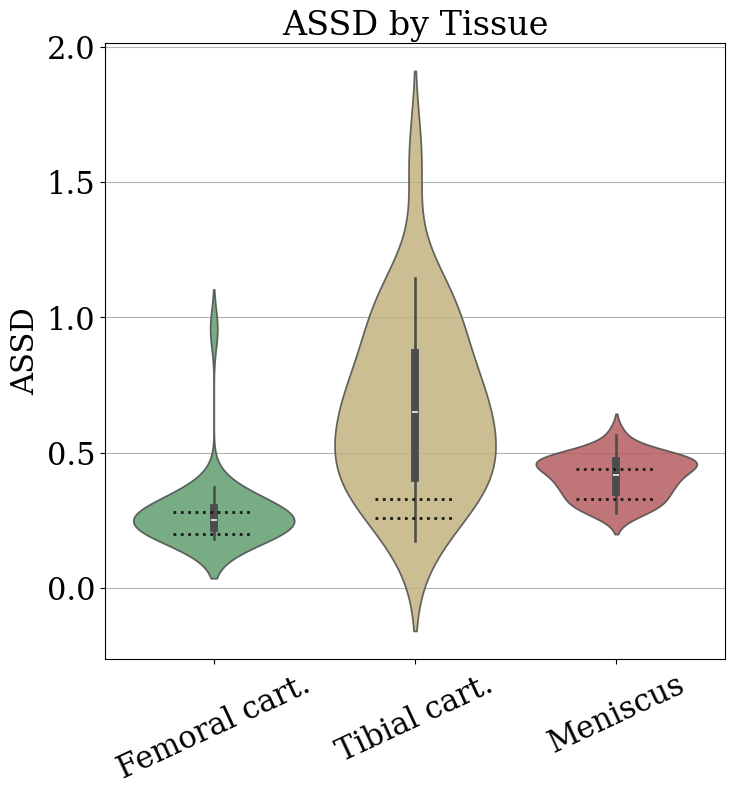

In [ ]:
violin_plot(
    data=manet_all_assd_all_classes,
    ylabel="ASSD",
    title="ASSD by Tissue",
    filename="manet_assd_by_tissue_violin",
    ref_high=iwoai_assd_high,
    ref_low = iwoai_assd_low,
    remove_patellar=True
  )

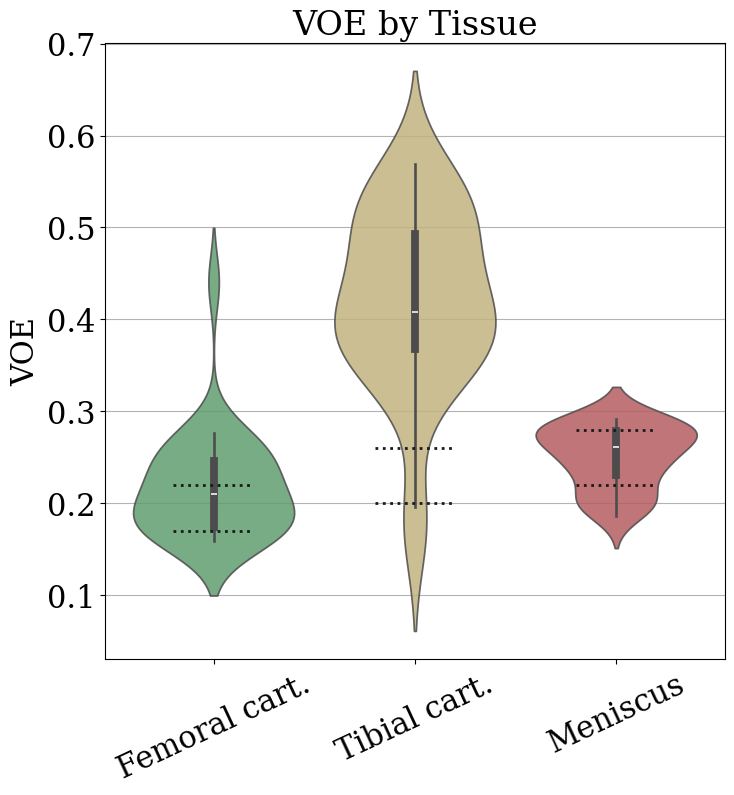

In [ ]:
violin_plot(
    data=manet_all_voe_all_classes,
    ylabel="VOE",
    title="VOE by Tissue",
    filename="manet_voe_by_tissue_violin",
    ref_high=iwoai_voe_high,
    ref_low=iwoai_voe_low,
    remove_patellar=True

)